<h1> Python Fundamentals <h1>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pylab as plt
from dataprep.clean import clean_country
import pygal
import folium

Fontconfig warning: ignoring UTF-8: not a valid region tag


<h3>Merge Two CSV Files <h3>

In [2]:
# merge the two csv files together into a data frame
articleInfo = pd.read_csv("articleInfo.csv")
authorInfo = pd.read_csv("authorInfo.csv")

mergedInfo = pd.merge(articleInfo, authorInfo, 
                   on="Article No.", 
                   how="inner")
mergedInfo = mergedInfo.fillna(0)


<h3> Plot the <i>yearly_publication<i> figure <h3>

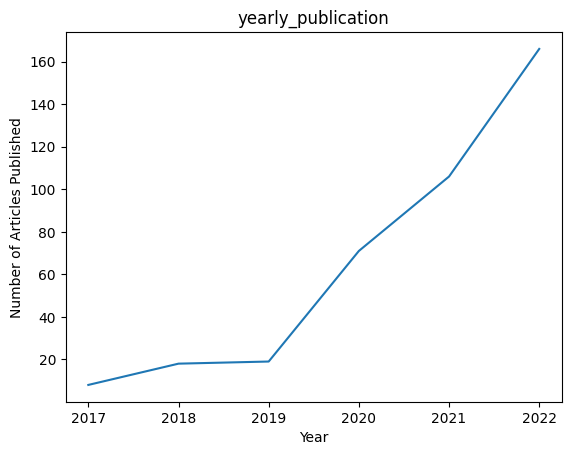

In [3]:
# plot the yearly publication figure: x - axis = year, y -axis = # articles published during that year
yearPub = mergedInfo.loc[:,"Year"].to_list() 
numArticles = {i:yearPub.count(i) for i in yearPub}

lists = sorted(numArticles.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.xlabel('Year')
plt.ylabel('Number of Articles Published')
plt.title("yearly_publication")

plt.plot(x, y)
plt.show()

<h3> Plot the <i>yearly_citation<i> figure <h3>

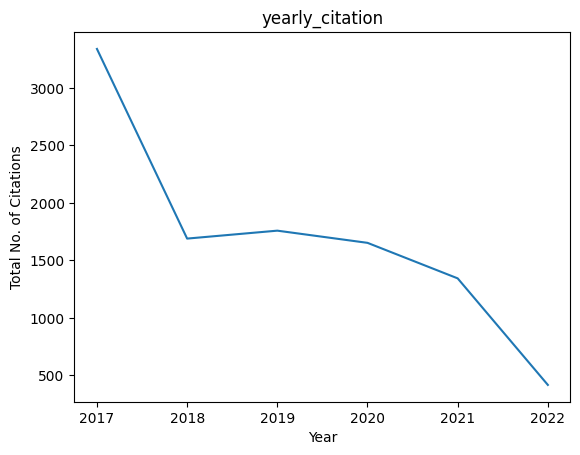

In [4]:
# plot the yearly citation figure: x axis is the year and the y axis is the total # of citations in that year
yearPub = mergedInfo.loc[:,"Year"].to_list()
citations = mergedInfo.loc[:,"Citation"].to_list()

# create new data frame with information we want
temp = {"Year": yearPub, "Citation" : citations}
newDF = pd.DataFrame(temp)

# get the sum of the citations for each year and convert to dictionary
citations = newDF.groupby('Year')['Citation'].sum().to_dict()
x = citations.keys()
y = citations.values()

# plot the data
plt.plot(x, y)
plt.xlabel("Year")
plt.ylabel("Total No. of Citations")
plt.title("yearly_citation")
plt.show()


<h3> Plot the number of publications across countries<h3>

In [5]:
# get the number of publications per country
countriesPB = mergedInfo.loc[:,"Country"].to_list()
numCountries = {i:countriesPB.count(i) for i in countriesPB}

keys = numCountries.keys()
value = numCountries.values()

# convert the names to iso standard
df = pd.DataFrame({"Countries" : keys, "Number of Publications" : value})

df["Countries"] = df["Countries"].replace("Denamrk", "Denmark")
df["Countries"] = df["Countries"].replace("Chian", "China")
df["Countries"] = df["Countries"].replace("Palastine", "Palestine")
df["Countries"] = df["Countries"].replace("USA", "United States of America")

df = clean_country(df, "Countries",  input_format=("name", "official", "alpha-3"))
# get the alpha code for the country in order to make into map
df = clean_country(df, "Countries_clean", output_format="alpha-3")
# if nan -> remove
df = df.dropna()

# create a new dataframe and use to plot the map
publicationData = df[['Countries_clean_clean', 'Number of Publications']].copy()
publicationData.columns = ['CODE', "Num of Publications"]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent',
                 'name', 'CODE', 'gdp_md_est', 'geometry']
merge = pd.merge(world, publicationData, on='CODE', how = 'inner')
worldData = gpd.GeoDataFrame(merge)

m = worldData.explore(
    column="Num of Publications",
     scheme="naturalbreaks",
     legend=False, 
     k=10, 
     legend_kwds=dict(colorbar=False),
     name="countries"
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map
  


/Users/mayasingh/Documents/GitHub/ML-Assignment-1/env/lib/python3.10/site-packages/dask/dataframe/core.py:6799: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	7 values cleaned (17.5%)
	2 values unable to be parsed (5.0%), set to NaN
Result contains 38 (95.0%) values in the correct format and 2 null values (5.0%)


/Users/mayasingh/Documents/GitHub/ML-Assignment-1/env/lib/python3.10/site-packages/dask/dataframe/core.py:6799: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	38 values cleaned (95.0%)
Result contains 38 (95.0%) values in the correct format and 2 null values (5.0%)


<h3> Top 5 Institutions and Researchers <h3>

In [6]:
# top 5 institutions and top 5 researchers
# collect institution information and make dataframe
institution = mergedInfo.loc[:, "Author Affiliation"].to_list()
numInstitutions = {i: institution.count(i) for i in institution}
institutionKeys = numInstitutions.keys()
institutionValue = numInstitutions.values()
institutionDF = pd.DataFrame({"Institution": institutionKeys, "Number of Publications": institutionValue})
institutionDF = institutionDF.sort_values(by = 'Number of Publications', ascending=False)

# collect researcher information and make dataframe with h-index
researcher = mergedInfo.loc[:, "Author Name"].to_list()
hindex = mergedInfo.loc[:,"h-index"].to_list()
researcherDF = pd.DataFrame(
    {"Researcher": researcher, "H-Index": hindex})
researcherDF = researcherDF.sort_values(by='H-Index', ascending= False)

display(institutionDF)
display(researcherDF)


,Institution,Number of Publications
4,University of the Western Cape,17
69,Masaryk University,12
32,University College Cork,11
96,Intel Corporation,11
59,Madigan Army Medical Center,8
...,...,...
30,Tangshan Normal University,1
95,Huanghuai University,1
31,Xingtai University,1
91,International Ataturk Alatoo University,1


,Researcher,H-Index
117,Ulrich Trautwein,95.0
102,Nicolas Molinari,63.0
130,George S. Athwal,59.0
140,Maria Luisa Lorusso,33.0
147,Vicente A. González,33.0
...,...,...
150,Jason Bothwell,0.0
149,Chad Gorbatkin,0.0
144,Jared Thomas,0.0
143,Rafael Sacks,0.0
